In [298]:
import torch
from pathlib import Path
import os
import random
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [299]:
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import os

# Set your root dataset directory
root_dir = Path("D:/CSM character classifier/data/Train data")

# Loop through all image files recursively
for img_path in root_dir.rglob("*.*"):
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify image integrity
    except (UnidentifiedImageError, OSError):
        print(f"Corrupted: {img_path}")
        os.remove(img_path)


In [300]:
image_data = Path("D:\CSM character classifier\data")
labels = ['Aki', "Denji", "Makima", "Power"]
for path, dirnames, filenames in os.walk(image_data):
    print(f"There are {len(dirnames)} files, {len(filenames)} images a in {path}")

There are 2 files, 0 images a in D:\CSM character classifier\data
There are 4 files, 0 images a in D:\CSM character classifier\data\Test data
There are 0 files, 84 images a in D:\CSM character classifier\data\Test data\Aki
There are 0 files, 56 images a in D:\CSM character classifier\data\Test data\Denji
There are 0 files, 95 images a in D:\CSM character classifier\data\Test data\Makima
There are 0 files, 100 images a in D:\CSM character classifier\data\Test data\Power
There are 4 files, 0 images a in D:\CSM character classifier\data\Train data
There are 0 files, 413 images a in D:\CSM character classifier\data\Train data\AKI
There are 0 files, 499 images a in D:\CSM character classifier\data\Train data\Denji
There are 0 files, 500 images a in D:\CSM character classifier\data\Train data\Makima
There are 0 files, 498 images a in D:\CSM character classifier\data\Train data\Power


In [301]:
train_path = image_data/"Train data"
test_path = image_data/'Test data'

In [302]:
image_path_list = []
image_path_list.extend(list(image_data.rglob("*.jpg")))
image_path_list.extend(list(image_data.rglob("*.png")))

len(image_path_list)

2244

image path:  D:\CSM character classifier\data\Train data\Power\362.jpg
image width:  1725
image height:  2015


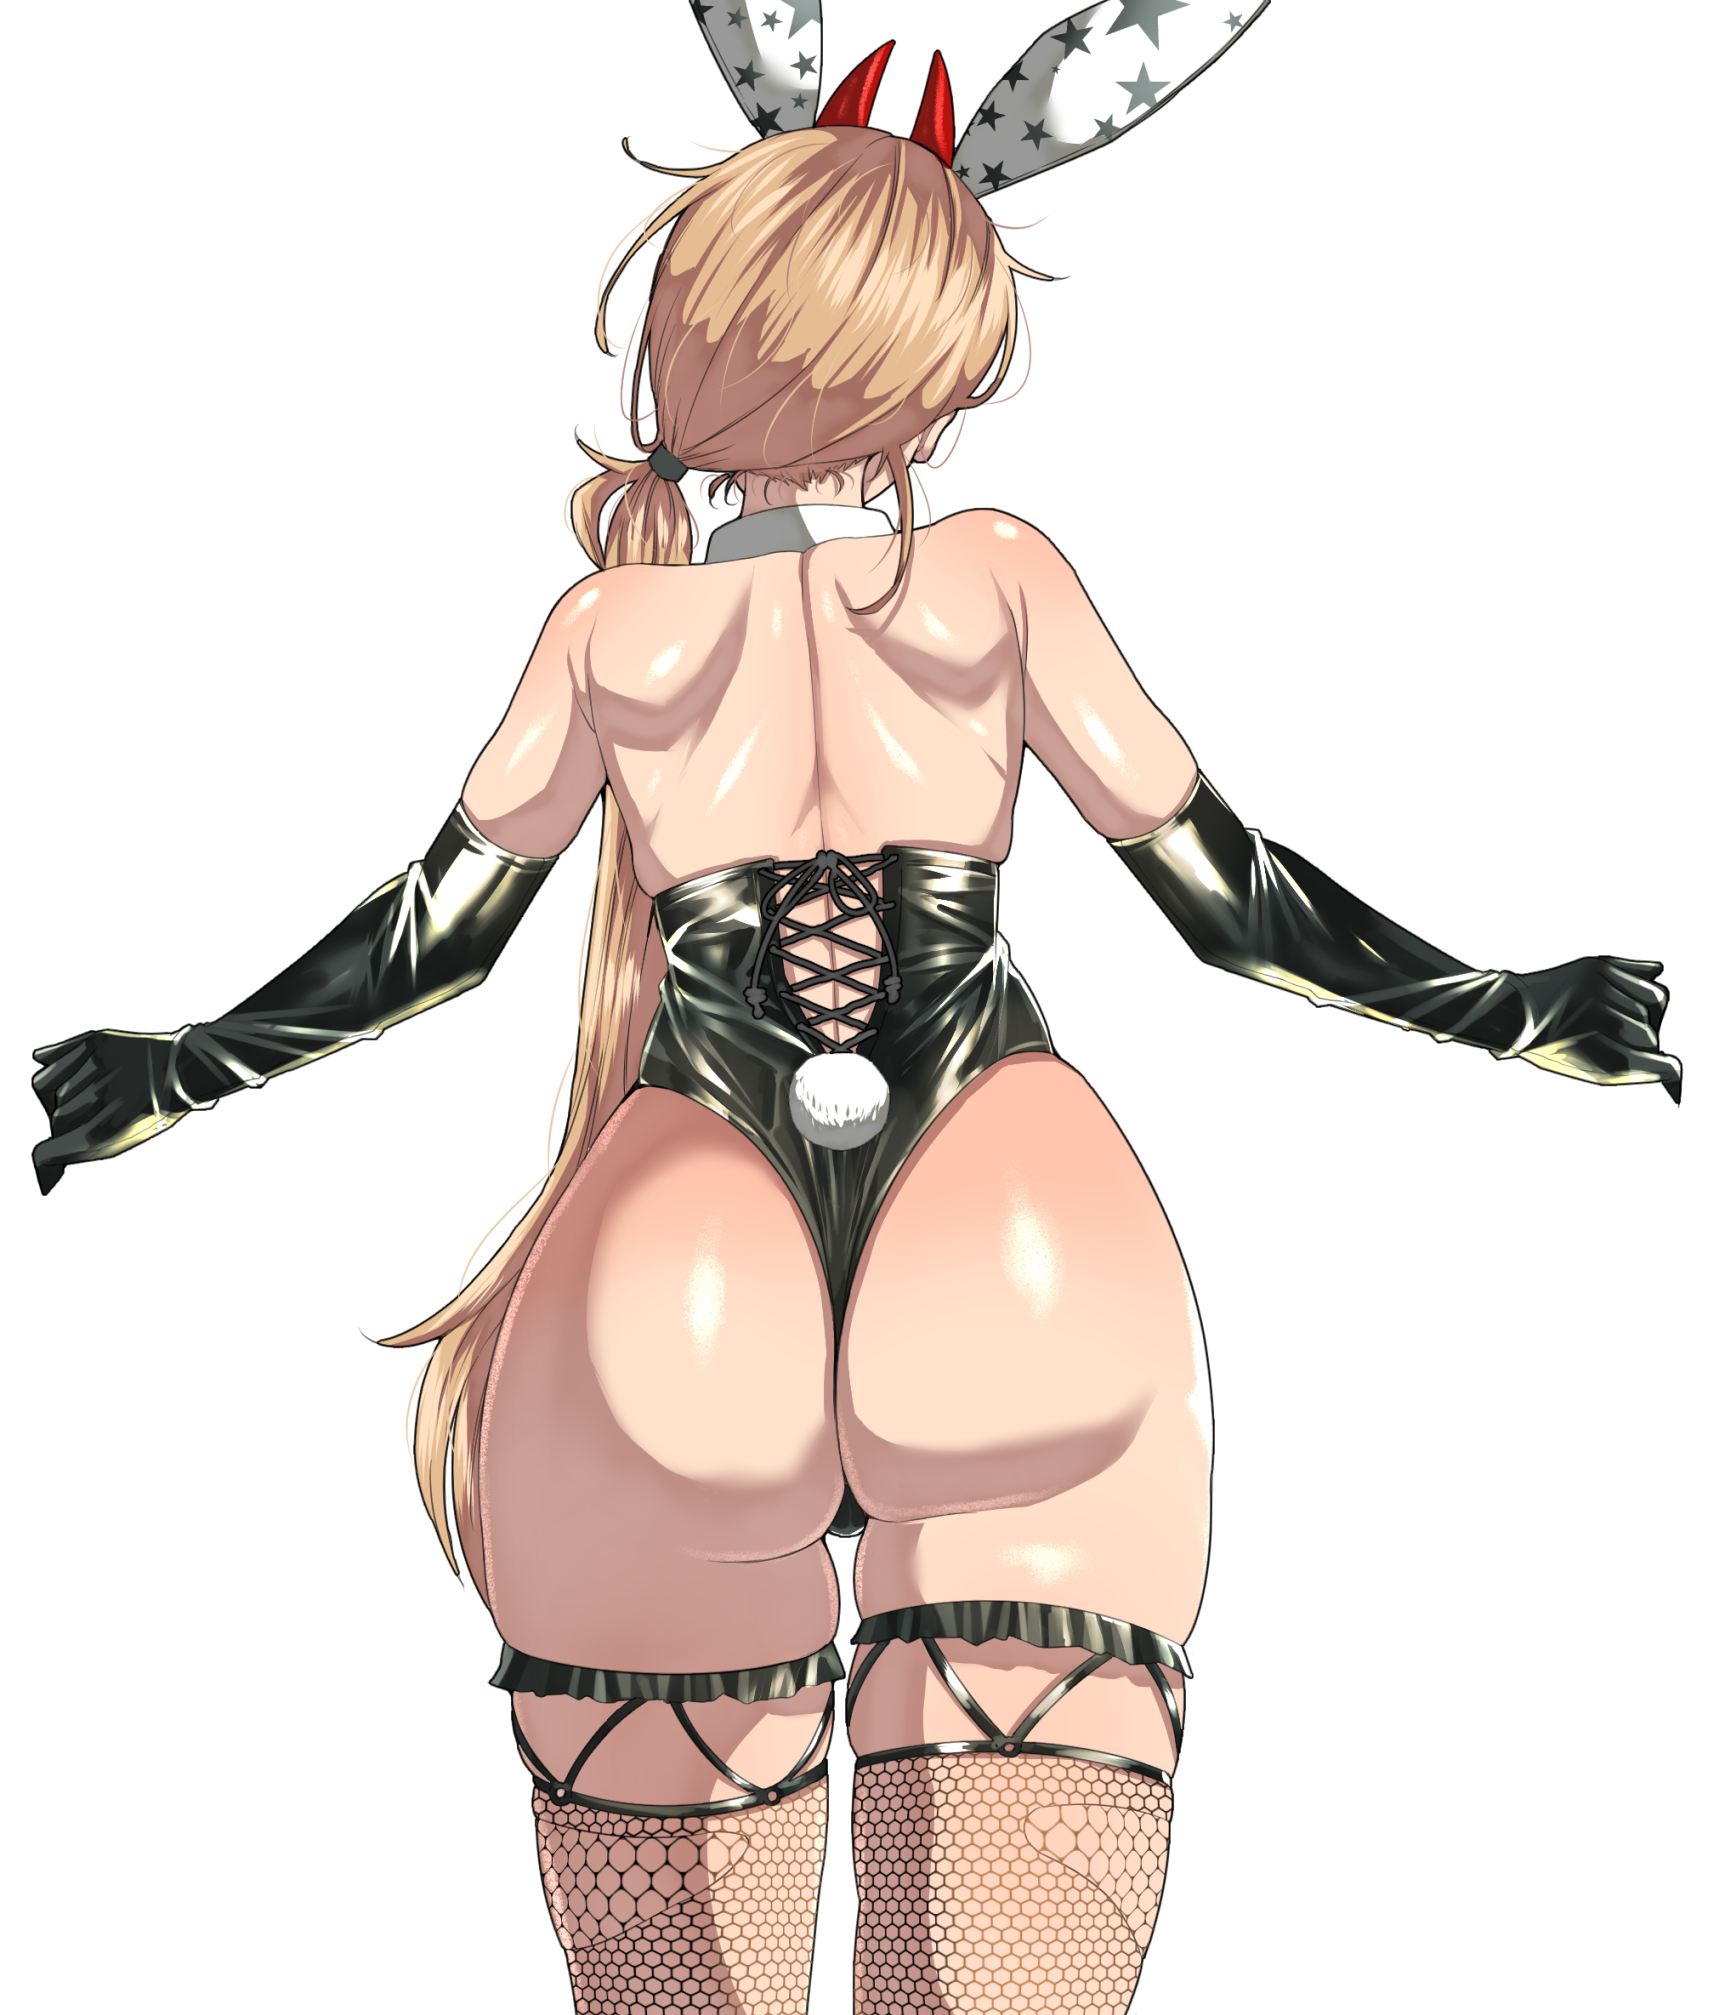

In [303]:
random_image_path = random.choice(image_path_list)
img_rand = Image.open(random_image_path)
print("image path: ", random_image_path)
print("image width: ", img_rand.width)
print("image height: ", img_rand.height)
img_rand

In [304]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),                           # Keep angle small
    #transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),              # Slight jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) 
])

train_dataset = ImageFolder(train_path, transform=train_transform)
test_dataset = ImageFolder(test_path, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [305]:
img, l = next(iter(train_loader))

imgs =img[0].permute(1, 2, 0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].


Power


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

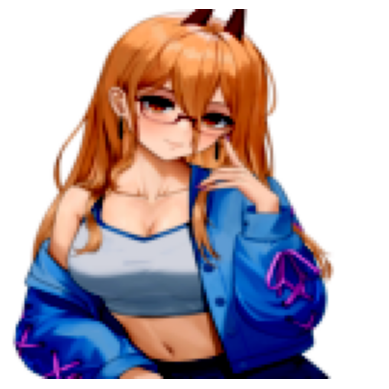

In [306]:
print(labels[l[0]])
plt.imshow(imgs)
plt.axis(False)

In [307]:
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.block5 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=8410, out_features=4)
        )
    def forward(self, x):
        return self.block5(self.block4(self.block3(self.block2(self.block1(x)))))

model0 = ConvolutionalNN().to(device=device)
optimizer = torch.optim.Adam(model0.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [317]:
def trainingloop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                  loss_func: torch.nn.modules.loss._Loss, optimize: torch.optim.Optimizer, device: torch.device= device):
    from sklearn.metrics import accuracy_score
    model.train()
    trainloss = 0
    accuracy = 0
    for (x, y) in (dataloader):
        x, y = x.to(device), y.to(device)
        ypred = model(x)
        preds = ypred.argmax(dim=1).cpu()
        loss = loss_func(ypred, y)
        trainacc = accuracy_score(y_true=y.cpu(), y_pred=preds)
        trainloss += loss.item()
        accuracy += trainacc
        
        optimize.zero_grad()

        loss.backward()

        optimize.step()
    trainloss /= len(dataloader)
    accuracy /= len(dataloader)
    print(f"Trainning loss= {trainloss} | Test Accuracy = {accuracy}")

In [318]:
def testingloop(model: torch.nn.Module, dataloader: torch.utils.data.dataloader, loss_func: nn.modules.loss._Loss, device: torch.device= device):
    model.eval()
    testloss = 0
    accuracy = 0
    from sklearn.metrics import accuracy_score
    with torch.inference_mode():
        for(x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            preds = ypred.argmax(dim=1).cpu()
            loss = loss_func(ypred, y)
            testacc = accuracy_score(y.cpu(), preds)
            testloss += loss.item()
            accuracy += testacc
        testloss /= len(dataloader)
        accuracy /= len(dataloader)
        print(f"Test loss= {testloss} | Test Accuracy = {accuracy}")

In [319]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print("_______________________\nEpoch: {epoch}\n______________________________________")
    trainingloop(model0, train_loader, loss_fn,optimizer, device)
    testingloop(model0, test_loader, loss_fn, device)

  0%|          | 0/3 [00:00<?, ?it/s]

_______________________
Epoch: {epoch}
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.9242990036805471 | Test Accuracy = 0.6489583333333333


 33%|███▎      | 1/3 [02:01<04:02, 121.30s/it]

Test loss= 1.0528714006597346 | Test Accuracy = 0.6130681818181819
_______________________
Epoch: {epoch}
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.9065500487883885 | Test Accuracy = 0.6442234848484849


 67%|██████▋   | 2/3 [04:00<01:59, 119.87s/it]

Test loss= 1.1169747059995478 | Test Accuracy = 0.6227272727272727
_______________________
Epoch: {epoch}
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.8796603173017502 | Test Accuracy = 0.6623579545454545


100%|██████████| 3/3 [05:59<00:00, 119.69s/it]

Test loss= 0.9735909646207636 | Test Accuracy = 0.6166666666666667
